# Import libraries

In [3]:
%pylab notebook
from __future__ import print_function
import datacube
import pandas as pd
import xarray as xr
from datetime import date, timedelta
from datacube.helpers import ga_pq_fuser
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets
import rasterio
from datacube_stats.statistics import GeoMedian

dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


# User requirement: specifiy location of interest and date of cyclone

In [4]:
###User input: enter area of interest
lat_min = -17.968 #down
lat_max = -17.925 #up
lon_min = 146.127 #left
lon_max = 146.186 #right
   
###User input: enter start and end date of cyclone
start_of_event= '2011-01-26'
end_of_event= '2011-02-06'

# No more user requirements. Just run remaining cells.

In [5]:
# Temporal range and bands of interest are defined

#Define temporal range
start_of_epoch = '2000-01-01'
end_of_epoch =  '2016-12-31'

#Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
bands_of_interest = ['green',
                     'red', 
                     'nir',
                     'swir1']

#Define sensors of interest, # out sensors that aren't relevant for the time period
sensors = ['ls8', #May 2013 to present
    'ls7', #1999 to present
    'ls5' #1986 to present, full contintal coverage from 1987 onwards
    ] 


#Build query
query = {'time': (start_of_epoch, end_of_epoch),}  
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

print(query)

{'time': ('2000-01-01', '2016-12-31'), 'x': (146.127, 146.186), 'y': (-17.925, -17.968), 'crs': 'EPSG:4326'}


In [6]:
#reformat event date format 

start_of_event=datetime.datetime.strptime(start_of_event,'%Y-%m-%d') #Convert to datetime
end_of_event=datetime.datetime.strptime(end_of_event,'%Y-%m-%d') #Convert to datetime

# Extract information from Open Data Cube

In [7]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

In [8]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}
cloud_free_threshold = 0.80  ###User modification: set cloud threshold. Default value is "0.90" or >90% image and <10% cloud cover
                        ###Scenes will not be retrieved that have less than the cloud threshold worth of image.

for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        
    #Discard data that does not meet the cloud_free_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [9]:
#Check the output

sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 57, x: 270, y: 218)
 Coordinates:
   * time     (time) datetime64[ns] 2003-06-29T23:52:33 ...
   * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
   * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...
 Data variables:
     green    (time, y, x) float64 420.0 478.0 478.0 478.0 478.0 420.0 420.0 ...
     red      (time, y, x) float64 45.0 93.0 93.0 93.0 93.0 93.0 93.0 93.0 ...
     nir      (time, y, x) float64 74.0 74.0 132.0 74.0 74.0 74.0 74.0 74.0 ...
     swir1    (time, y, x) float64 28.0 10.0 10.0 70.0 28.0 10.0 10.0 10.0 ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 135, x: 270, y: 218)
 Coordinates:
   * time     (time) datetime64[ns] 2000-01-21T00:09:11.500000 ...
   * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
   * x        (x) float64 1.493e+

In [10]:
#Concatenate (join) data from different sensors together and sort so that observations are sorted 
#by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), 'time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [11]:
#Check that the concatenation worked

nbar_clean

<xarray.Dataset>
Dimensions:  (time: 226, x: 270, y: 218)
Coordinates:
  * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
  * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...
  * time     (time) datetime64[ns] 2000-01-21T00:09:11.500000 ...
Data variables:
    green    (time, y, x) float64 362.0 345.0 345.0 345.0 380.0 362.0 362.0 ...
    red      (time, y, x) float64 118.0 118.0 103.0 103.0 118.0 148.0 133.0 ...
    nir      (time, y, x) float64 87.0 87.0 87.0 87.0 87.0 87.0 87.0 87.0 ...
    swir1    (time, y, x) float64 36.0 57.0 36.0 36.0 78.0 57.0 57.0 57.0 ...
    product  (time) <U3 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' 'ls7' ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 1493450.00|\n| 0.00,-25.00,-1996550.00|\n| 0.00,...

# Landscape and NDVI of scene prior to cyclone

In [12]:
#Prepare imagery
rgb = nbar_clean.sel(time =start_of_event, method = 'pad').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


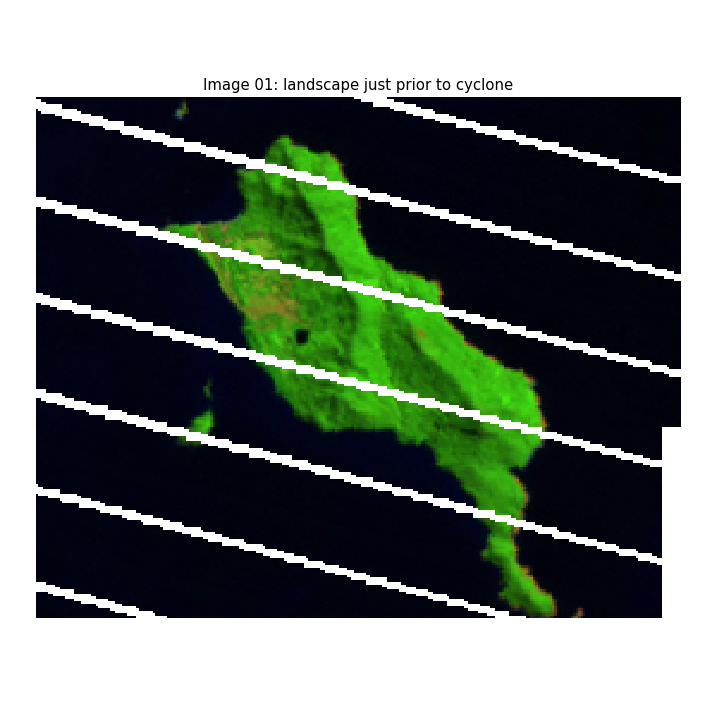

In [45]:
#Create image that shows landscape before cyclone

fig = plt.figure(figsize =(8,8)) #Edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions
fig.patch.set_facecolor('white') #Make border white 
fig.patch.set_alpha(0.99)#Ensure border white
plt.axis('off')#remove axis 
plt.title('Image 01: landscape just prior to cyclone') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image
plt.show() #show image

In [13]:
#Calculate NDVI
ndvi = ((nbar_clean.nir-nbar_clean.red)/(nbar_clean.nir+nbar_clean.red))
ndvi.attrs['crs'] = crs
ndvi.attrs['affine'] = affine

ndvi01= ndvi.sel(time =start_of_event, method = 'pad') #NDVI for scene just prior to cyclone

<IPython.core.display.Javascript object>


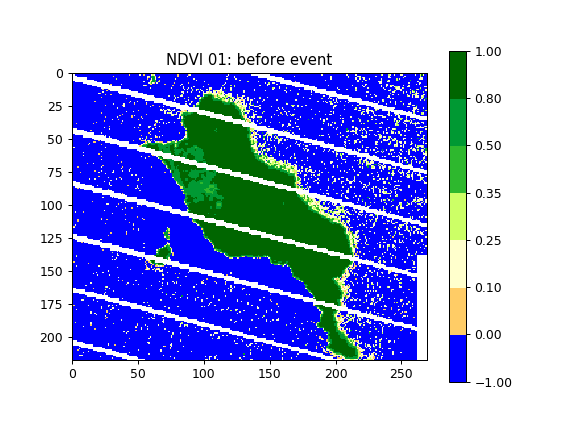

In [14]:
#Plot NDVI for scene prior to cyclone

#Controls for NDVI colour map
ndvi_cmap = mpl.colors.ListedColormap(['blue', '#ffcc66','#ffffcc' , '#ccff66' , '#2eb82e', '#009933' , '#006600'])
ndvi_bounds = [-1, 0, 0.1, 0.25, 0.35, 0.5, 0.8, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

#Create plot
fig = plt.figure() #create plot
plt.title('NDVI 01: before event') #add title
i=plt.imshow(ndvi01,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm) #create image with colourbar
fig.colorbar(i) #add colour bar

# Landscape and NDVI of scene after cyclone

In [15]:
#Prepare imagery for scene after cyclone
rgb02 = nbar_clean.sel(time =end_of_event, method = 'backfill').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb02 = rgb02.astype('double')
clipped_visible02 = rgb02.where(rgb02<fake_saturation).fillna(fake_saturation)
max_val02 = clipped_visible02.max(['y', 'x'])
scaled02 = (clipped_visible02 / max_val02)

/g/data/v10/public/modules/agdc-py3-env/20171016/envs/agdc/lib/python3.6/site-packages/xarray/core/variable.py:1164: RuntimeWarning: invalid value encountered in less
  if not reflexive


<IPython.core.display.Javascript object>


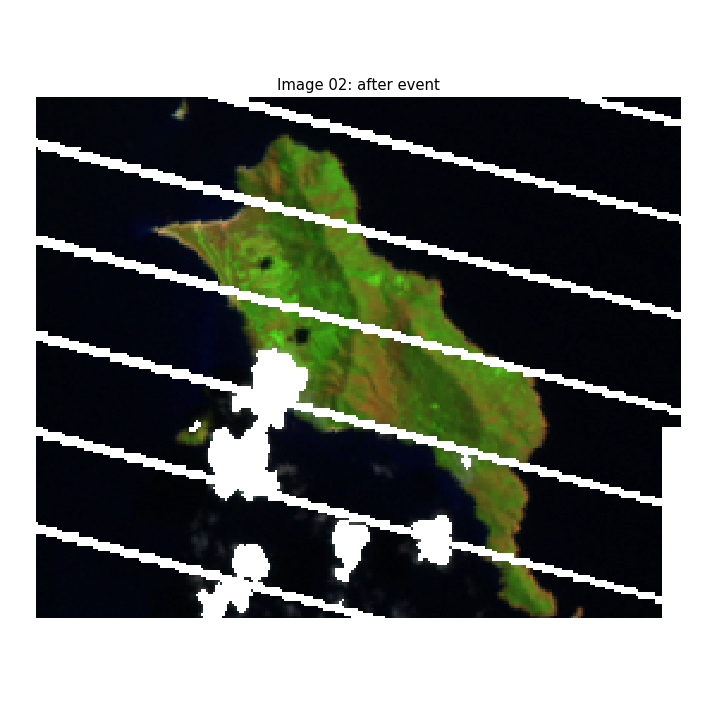

In [15]:
#Create small area image for the event of interest

fig = plt.figure(figsize =(8,8)) #Edit size of plot ##User should format as required
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99)#Make border white ##User should format if required
plt.axis('off')#remove axis ##User should delete code if required
plt.title('Image 02: after event')
plt.imshow(scaled02, interpolation = 'nearest')
#            extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
#                   scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.show() #Create plot

In [16]:
ndvi02= ndvi.sel(time =end_of_event, method = 'backfill')
ndvi02

<xarray.DataArray (y: 218, x: 270)>
array([[ 0.      ,  0.218107,  0.045226, ...,  0.147541,  0.147541, -0.122302],
       [ 0.      ,  0.1341  , -0.041475, ...,  0.044776, -0.22293 ,  0.044776],
       [ 0.045226,  0.315556,  0.218107, ..., -0.122302, -0.302857, -0.122302],
       ..., 
       [-0.174603, -0.114894, -0.114894, ...,       nan,       nan,       nan],
       [-0.364583, -0.364583, -0.416268, ...,       nan,       nan,       nan],
       [-0.364583, -0.416268, -0.275261, ...,       nan,       nan,       nan]])
Coordinates:
  * y        (y) float64 -1.997e+06 -1.997e+06 -1.997e+06 -1.997e+06 ...
  * x        (x) float64 1.493e+06 1.493e+06 1.494e+06 1.494e+06 1.494e+06 ...
    time     datetime64[ns] 2011-03-24T00:09:57.500000
Attributes:
    crs:      EPSG:3577
    affine:   | 25.00, 0.00, 1493450.00|\n| 0.00,-25.00,-1996550.00|\n| 0.00,...

<IPython.core.display.Javascript object>


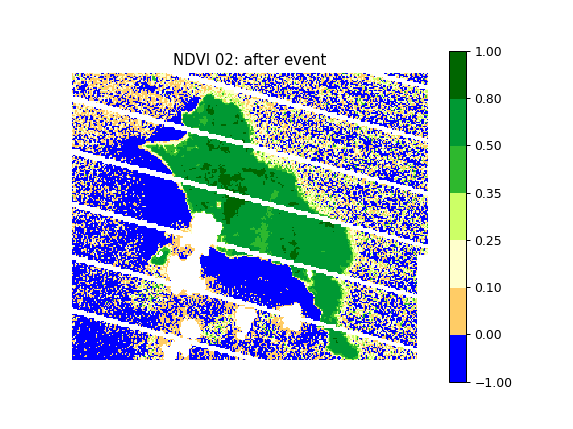

(-0.5, 269.5, 217.5, -0.5)

In [17]:
fig = plt.figure()
plt.title('NDVI 02: after event' )
i=plt.imshow(ndvi02,interpolation = 'nearest', cmap = ndvi_cmap, norm = ndvi_norm)
fig.colorbar(i)
plt.axis('off')#remove axis ##User should delete code if required

# Change in vegetation before/after cyclone

In [18]:
ndvi_change= ndvi02-ndvi01
# ndvi_change=(((ndvi_change-np.amin(ndvi_change))/(np.amax(ndvi_change)-np.amin(ndvi_change)))*100)

<IPython.core.display.Javascript object>


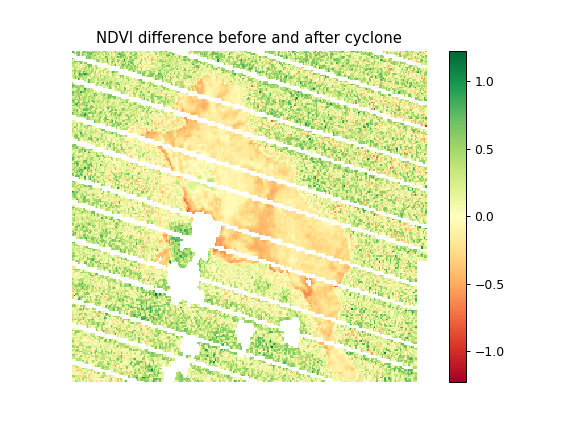

In [19]:
fig = plt.figure()
ndvi_change.plot(cmap = 'RdYlGn')
plt.title('NDVI difference before and after cyclone')
plt.axis('off')#remove axis ##User should delete code if required
plt.show()